## Семинар 3 "Определение ключевых точек лица"

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Для **зачета** дз нужно сделать одно из двух:

1. Исследовать 6 разных архитектур и написать подробный вывод + мысли почему одна сеть работает лучше чем другая (разные функции активации, глубины сетей, размеры и типы слоев)
2. Преодолеть порог MSE=8 на тесте


Также до  22 марта 23:59 можно получить до 5 дополнительных баллов за лучшее решение. (За первое место 5 баллов, за второе — 3 балла, за третье — 1 балла.)

Для решения можно пользоваться всем инструментарием, с которым мы познакомимся:  предобученные модели, сверточные сети, любые оптимизаторы, batchnorm, dropout, etc.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, L1Loss, Module, Parameter
from torch.nn import Flatten,Dropout, LayerNorm, Sequential,\
                        Module, Conv2d, BatchNorm2d, ReLU, MaxPool2d, BatchNorm1d
from torch.autograd import Variable
# Ignore warnings
import warnings
from skimage import filters
from skimage.util import random_noise
from sklearn.metrics import mean_squared_error as l2

base_dir = 'drive/MyDrive/Colab Notebooks/tests/'

try:
    from tensorboardX import SummaryWriter
except ImportError:
    raise RuntimeError("No tensorboardX package is found. Please install with the command: \npip install tensorboardX")

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]
Image shape (96, 96)


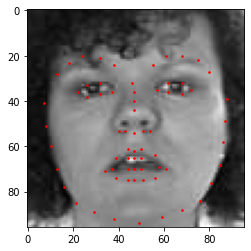

In [5]:
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv(base_dir + 'dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].values.astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))
print('Image shape {}'.format( io.imread(os.path.join(base_dir + 'dataset/train/', img_name)).shape  ) )

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
img = io.imread(os.path.join(base_dir + 'dataset/train/', img_name))
show_landmarks(img, landmarks)
plt.show()

In [6]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    """ y_pred: (batch_size, fp_num, 2) """
    images_batch, landmarks_batch = sample_batch
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [7]:
min_arr = np.load( base_dir + 'min_arr.npy' )
max_arr = np.load( base_dir + 'max_arr.npy' )

In [8]:
class RandomBlur(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, sigma_range=1.0):
        assert isinstance(sigma_range, (float))
        self.sigma_range = sigma_range
        

    def __call__(self, sample):
        image, landmarks = sample
        
        sigma = np.random.uniform(0.0, self.sigma_range, 1)[0]
        image = filters.gaussian(image, sigma=sigma)

        return image, landmarks


class RandomSP(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, amount_range=0.001):
        assert isinstance(amount_range, (float))
        self.amount_range = amount_range
        
        
    def __call__(self, sample):
        image, landmarks = sample
        
        amount = np.random.uniform(0.0, self.amount_range, 1)[0]
        image = random_noise(image, mode='s&p', amount=amount, clip=True)

        return image, landmarks


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
    
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        
        
        landmarks = landmarks * [new_w / w, new_h / h]

        # shift = (new_h - h) // 2
        # img = np.pad(image, shift, mode='constant')
        # landmarks = landmarks + [shift, shift]

        return img, landmarks


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    
    def __call__(self, sample):
        image, landmarks = sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return image, landmarks
    

class RandomRotate(object):
    # img, facepoints, alpha_degree
    
    def __init__(self, degree_range):
        assert isinstance(degree_range, (int))
        assert degree_range >= 1
        self.degree_range = degree_range
    
    
    def __call__(self, sample):
        image, landmarks = sample
        
        alpha_degree = np.random.randint(-self.degree_range, self.degree_range, 1)[0]
        new_img = transform.rotate(image, alpha_degree, mode='constant') # mode='edge'
        
        # center = (image.shape[0] / 2 - 0.5, image.shape[1] / 2 - 0.5) # как в skimage.transform.rotate
        # center = (image.shape[0] // 2, image.shape[1] // 2)
        center = (image.shape[0] / 2, image.shape[1] / 2)
        landmarks = np.copy(landmarks)
        
        vector = landmarks - center
        alpha_radian = -np.radians(alpha_degree)
        rm = np.array([[np.cos(alpha_radian), -np.sin(alpha_radian)],
                      [np.sin(alpha_radian), np.cos(alpha_radian)]], dtype='float32')
        
        vector = (rm.dot(vector.T)).T
        
        landmarks = (vector + center).astype(dtype=int)
        
        return new_img, landmarks


class Normalize(object):
    
    def __init__(self, mean=0.4940668, std=0.22909011):
        self.mean = mean
        self.std = std 

    def __call__(self, sample):
        image, landmarks = sample
        #return (image - self.mean) / self.std, landmarks
        return (image - min_arr) / (max_arr - min_arr), landmarks
    


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample
        return torch.from_numpy(image).type(torch.float), torch.from_numpy(landmarks).type(torch.float)

In [22]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, device, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].values.astype('float')
        landmarks = landmarks.reshape(-1, 2)

        assert len(image.shape) == 2
            
        if self.transform:
            image, landmarks = self.transform((image, landmarks))
        
        image = image.reshape(1, *image.shape)
        landmarks = landmarks.reshape(68 * 2)
        sample = image.to(self.device), landmarks.to(self.device)

        return sample

In [23]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"

print(device)

cuda


In [24]:
train_dataset = FaceLandmarksDataset(csv_file=base_dir + 'dataset/train/face_landmarks.csv',
                                     root_dir=base_dir + 'dataset/train',
                                     device=device,
                                     transform=transforms.Compose([
                                                # RandomCrop(80),
                                                # Rescale(128), # 192 128
                                                # Normalize(),
                                                #RandomCrop(128),
                                                # RandomRotate(10),
                                                # RandomSP(),
                                                # RandomBlur(),
                                               #RandomCrop(127),
                                                ToTensor()
                                           ]))

test_dataset = FaceLandmarksDataset(csv_file=base_dir + 'dataset/test/face_landmarks.csv',
                                     root_dir=base_dir + 'dataset/test',
                                     device=device,
                                     transform=transforms.Compose([
                                               # Rescale(128),
                                               # Normalize(),
                                               #RandomCrop(96),
                                               ToTensor()
                                           ]))

In [25]:
def get_data_loaders(train_batch_size=16, val_batch_size=16): # 16

    train_loader = DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=val_batch_size, shuffle=False
    )

    return train_loader, test_loader

In [26]:
class Net(Module):

    def __init__(self, input_shape=(1, 96, 96)): # 96
        """ input_shape = (c, h, w)"""
        super().__init__()
        
        self.cv1 = Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1) 
        self.ac1 = ReLU()
        self.bn1 = BatchNorm2d(32)
        self.ap1 = MaxPool2d(kernel_size=2) # 48
        
        self.cv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) 
        self.ac2 = ReLU()
        self.bn2 = BatchNorm2d(64)
        
        self.cv3 = Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1) 
        self.ac3 = ReLU()
        self.bn3 = BatchNorm2d(64)
        self.ap2 = MaxPool2d(2) # 24
        
        self.cv4 = Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1) 
        self.ac4 = ReLU()
        self.bn4 = BatchNorm2d(64)
        
        self.cv5 = Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1) 
        self.ac5 = ReLU()
        self.bn5 = BatchNorm2d(64)
        self.ap3 = MaxPool2d(2) # 12
        
        self.cv6 = Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) 
        self.ac6 = ReLU()
        self.bn6 = BatchNorm2d(128)
        
        self.cv7 = Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1) 
        self.ac7 = ReLU()
        self.bn7 = BatchNorm2d(128)
        self.ap4 = MaxPool2d(2) # 6
        
        self.cv8 = Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) 
        self.ac8 = ReLU()
        self.bn8 = BatchNorm2d(256)

        self.ln1 = Linear(256 * 6 * 6, 1024) # 32 * 6 * 6 # 256 * 8 * 8
        self.ac9 = ReLU()
        self.bn9 = BatchNorm1d(1024)

        self.ln2 = Linear(1024, 68 * 2)

        self.layers = [
            
            self.cv1,
            self.ac1,
            self.bn1,
            self.ap1,

            self.cv2,
            self.ac2,
            self.bn2,

            self.cv3,
            self.ac3,
            self.bn3,
            self.ap2,

            self.cv4, 
            self.ac4,
            self.bn4,

            self.cv5, 
            self.ac5,
            self.bn5,
            self.ap3,

            self.cv6,
            self.ac6,
            self.bn6,

            self.cv7,
            self.ac7,
            self.bn7,
            self.ap4,

            self.cv8,
            self.ac8,
            self.bn8,
            
            lambda y: y.view(-1, y.shape[-1] * y.shape[-2] * y.shape[-3]),

            self.ln1,
            self.ac9,
            self.bn9,

            self.ln2
        ]
        
    def forward(self, x):
        
        for layer in self.layers:
            x = layer(x)
        
        return x

In [30]:
network = Net()
network.to(device)

train_dataloader, test_dataloader = get_data_loaders()
writer = SummaryWriter(filename_suffix='first', logdir="logs")
    
criterion = MSELoss()
optim = torch.optim.Adam
learning_rate = 0.001 # 0.001
max_epochs = 10 # 50

optimizer = optim(network.parameters(), lr=learning_rate)

trainer = create_supervised_trainer(network, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(
    network, metrics={"L2 loss": Loss(criterion), "L1 loss": Loss(L1Loss())}, device=device
)

training_history = {'l1':[],'l2':[]}
validation_history = {'l1':[],'l2':[]}
last_epoch = []

In [31]:
@trainer.on(Events.ITERATION_COMPLETED(every=10))
def log_training_loss(engine):
    writer.add_scalar("training/loss", engine.state.output, engine.state.iteration)
    writer.flush()


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_dataloader)
    metrics = evaluator.state.metrics
    l2_train = metrics["L2 loss"]
    l1_train = metrics['L1 loss']
    last_epoch.append(0)
    training_history['l2'].append(l2_train)
    training_history['l1'].append(l1_train)
    writer.add_scalar("training/epoch_loss", l2_train, trainer.state.epoch)
    
    evaluator.run(test_dataloader)
    metrics = evaluator.state.metrics
    l2 = metrics["L2 loss"]
    l1 = metrics['L1 loss']
    validation_history['l2'].append(l2)
    validation_history['l1'].append(l1)
    
    writer.add_scalar("validation/epoch_loss", l2, trainer.state.epoch)
    writer.flush()
    
    sys.stdout.write("\rTraining/Validation Results - Epoch: {}  Avg MSE: {:.2f} / {:.2f} Avg MAE: {:.2f} / {:.2f}"
          .format(trainer.state.epoch, l2_train, l2, l1_train, l1))
   

In [32]:
trainer.run(train_dataloader, max_epochs=max_epochs)

Training/Validation Results - Epoch: 10  Avg MSE: 5.30 / 6.05 Avg MAE: 1.58 / 1.67

State:
	iteration: 3890
	epoch: 10
	epoch_length: 389
	max_epochs: 10
	output: 8.94038200378418
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

### График функции потерь

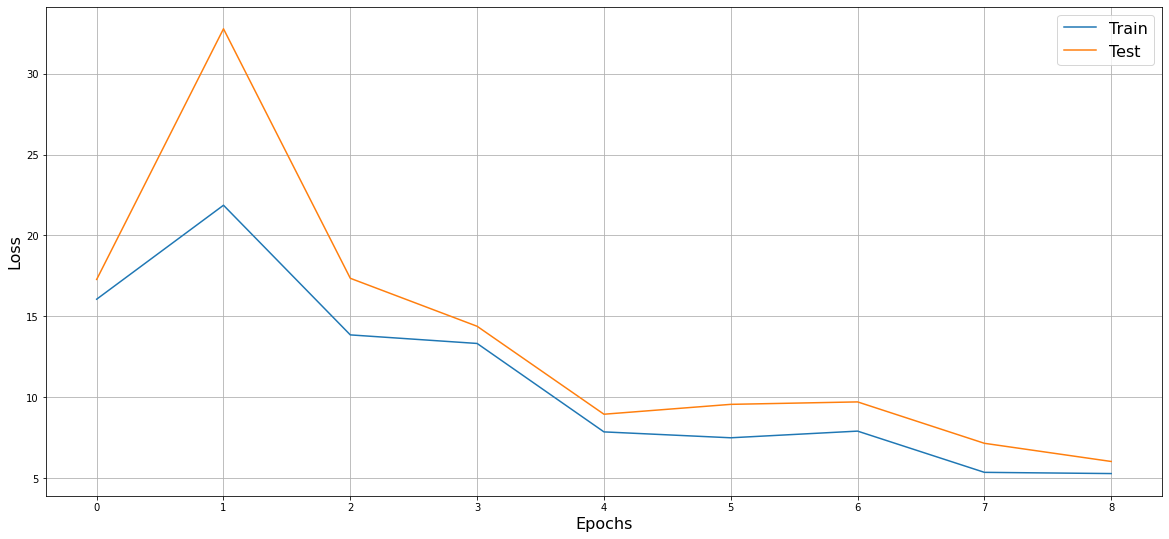

In [33]:
plt.figure(figsize=(20, 9))
plt.plot(training_history['l2'][1:], label='Train')
plt.plot(validation_history['l2'][1:], label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

### Итоговое качество с помощью функции потерь

In [34]:
evaluator.run(test_dataloader)
metrics = evaluator.state.metrics
l2 = metrics["L2 loss"]
l1 = metrics['L1 loss']

In [39]:
print('Test metrics:\nL2 loss: {}\nL1 loss: {}'.format(l2, l1))

Test metrics:
L2 loss: 6.048537430184078
L1 loss: 1.6678135693635934
